## Project 1 : Rocket landing using gradient-based and physics informed machine learning algorithms
### Problem Definition : 
This project considers a number of aspects which would make this rocket landing problem more realistic:
1. Choosing an aribitary postion for the rocket (x,y coordinate for position and orientation ($\theta$))
2. having a dynamic drag force associated to the rocket as a dynamic function
3. Considering a wind force with low frequency as a noise function
4. Considering force distribution for the initial state

The rocket landing is considered to be purely vertical. According to the initial conditions, the  rocket controll should be able  re-orient itself to a vertical orientation to sucessfully perform a verical landing. After considering the drag force, gravitational and thrust force. A figure is attached to get a better undertanding of the dynamic analysis. Using this the dynamic function is defined as: 

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}_{T}||^2 + ||v^{(i)}_{T}||^2 \\
\quad &x^{(i)}_{t+1} = x^{(i)}_{t} + v^{(i)}_{t}\Delta t + w^{(i)}_{t} \\
\quad &v^{(i)}_{t+1} = v^{(i)}_{t} + (g_{gravity} + (a_{drag}-a_{thrust})a^{(i)}_{t})\Delta t + u^{(i)}_{t} \\
\quad &a_{t}^{(i)} = NN_{\theta}(x^{(i)}_{t}), \forall t=1,...,T-1, \forall i=1,...,N\\
\quad & T = 100, N = 20\\
\end{aligned}
$$

where $x_{t}$ is the rocket position at current time $t$, $v_{t}$ is the rocket speed at current time $t$, $g_{gravity}$ is the gravity acceleartion (variable is set as 0.13), $a_{drag}$ is the drag constant (variable is set as 0.003), $a_{thrust}$ is the thrust constant (variable is set as 0.2), $\Delta t$ is the time interval, which is set as 0.1, $w_{t}$ and $u_{t}$ are the noise for state and dynamic function at the current time $t$ respectively. $a_{t}$ is the action output from neural network which is feed by $x_{t}$, $\theta$ is the parameter of the neural network.

We set the uniform distribution for the initial position and keep all the initial speed be equal to 0. The range of distribution is $[1, 2]m$. In this experiment, we randomly choose 20 initial state from its distribution.

![Image](https://github.com/toolazytokeep/Design-Optimization/blob/main/Project%201/Rocket%20Landing%20Force%20Frame.png?raw=true)

In [35]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

PLATFORM_WIDTH = 0.25  # landing platform width taken from sample
PLATFORM_HEIGHT = 0.06  # landing platform height taken from sample
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.13  # gravity constant
BOOST_ACCEL = 0.20  # thrust constant
ROTATION_ACCEL = 15  # rotation constant
DRAG_ACCEL = 0.003  # drag constant

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action, Noise, mean, variance):
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and drag
        delta_state = (DRAG_ACCEL - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action

        # Noise
        w = t.tensor([1, 0]) * t.tensor(np.random.normal(mean, variance, 1))
        u = t.tensor([0, 1]) * t.tensor(np.random.normal(mean, variance, 1))
        noise = w + u

        # Update velocity
        state = state + delta_state + delta_state_gravity

        # Update state
        step_mat = t.tensor([[1., 0.],
                             [FRAME_TIME, 1.]])
        if Noise == True:
            state = t.matmul(state, step_mat) + noise.float()
        else:
            state = t.matmul(state, step_mat)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, is_Noise, mean, variance):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.is_Noise = is_Noise
        self.mean = mean
        self.variance = variance

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action, self.is_Noise, self.mean, self.variance)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = np.ones((20, 2))
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2, 1)
            state[i][1] = 0
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return t.mean(state ** 2)

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss_list = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.loss_list.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(20)])
        for i in range(20):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.title('Position and Velocity plot for Rocket Landing')
        plt.xlabel('Rocket Position(m)')
        plt.ylabel('Rocket Velocity(m/s)')
        plt.show()

## 1. Training the controller without noise (Wind Force)

[1] loss: 1.554
[2] loss: 0.842
[3] loss: 0.458
[4] loss: 0.247
[5] loss: 0.156
[6] loss: 0.112
[7] loss: 0.087
[8] loss: 0.072
[9] loss: 0.061
[10] loss: 0.053
[11] loss: 0.045
[12] loss: 0.039
[13] loss: 0.034
[14] loss: 0.029
[15] loss: 0.022
[16] loss: 0.014
[17] loss: 0.010
[18] loss: 0.007
[19] loss: 0.004
[20] loss: 0.003
[21] loss: 0.002
[22] loss: 0.002
[23] loss: 0.001
[24] loss: 0.001
[25] loss: 0.001
[26] loss: 0.001
[27] loss: 0.000
[28] loss: 0.000
[29] loss: 0.000
[30] loss: 0.000


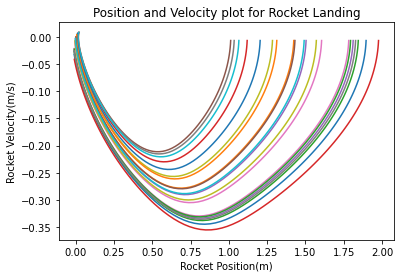

In [5]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = False
mean, variance = (0, 0.000001)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)

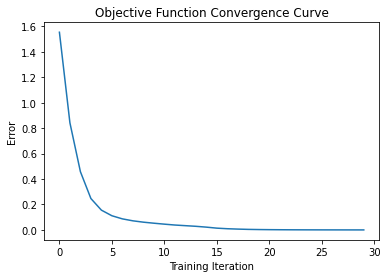

In [6]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

## Discussion
Firstly, we consider the state and dynamic function without noise. The aim of objective function is to guarantee that the rocket can land on the ground when reaching the final time, which means that the final positon of the rocket should be 0. Besides, the final speed of the rocket should be approximate to 0. The figure above shows the trajectory for rocket position and velocity. We can find the curves can arrive at 0 on the X axis (rocket position) and be close to 0 on the Y axis (rocket velocity), which means that the controller can meet the requirement of the design. The convergence curve shows that the objective function is minimized.   

# 2. Training the Controller with noise

Next, we add the noise in the state and dynamic function. We consider the Gaussian Distribution and choose the noise variable randomly from this distribution. Because the noise range (mean is 0, variance is $10^{-5}$) is very small, we speculate that the trajectory might be similar to the case without noise. The below figure supports our hypothesis and result shows that the controller can work well when having a very small perturbation.

[1] loss: 1.524
[2] loss: 0.826
[3] loss: 0.450
[4] loss: 0.247
[5] loss: 0.147
[6] loss: 0.094
[7] loss: 0.068
[8] loss: 0.056
[9] loss: 0.046
[10] loss: 0.037
[11] loss: 0.031
[12] loss: 0.027
[13] loss: 0.023
[14] loss: 0.016
[15] loss: 0.010
[16] loss: 0.007
[17] loss: 0.005
[18] loss: 0.003
[19] loss: 0.002
[20] loss: 0.002
[21] loss: 0.001
[22] loss: 0.001
[23] loss: 0.001
[24] loss: 0.001
[25] loss: 0.000
[26] loss: 0.000
[27] loss: 0.000
[28] loss: 0.000
[29] loss: 0.000
[30] loss: 0.000


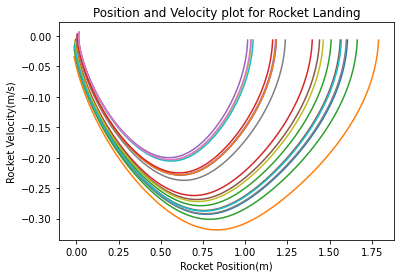

In [25]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 0.00001)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)
plt.show()

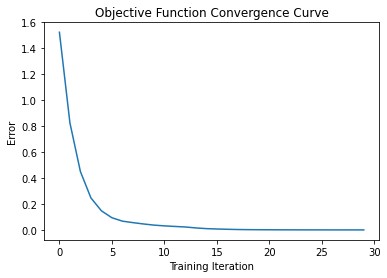

In [26]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

## 3. Training the Controller with large noise perturbation

We want to test the reliability of the controller when having a large noise perturbation. So we increase variance for the noise distribution, which is changed to $10^{-4}$.

[1] loss: 1.638
[2] loss: 1.629
[3] loss: 0.608
[4] loss: 0.553
[5] loss: 0.414
[6] loss: 0.410
[7] loss: 0.422
[8] loss: 0.393
[9] loss: 0.456
[10] loss: 0.397
[11] loss: 0.460
[12] loss: 0.410
[13] loss: 0.373
[14] loss: 0.468
[15] loss: 0.421
[16] loss: 0.408
[17] loss: 0.400
[18] loss: 0.449
[19] loss: 0.407
[20] loss: 0.409
[21] loss: 0.418
[22] loss: 0.397
[23] loss: 0.424
[24] loss: 0.423
[25] loss: 0.423
[26] loss: 0.474
[27] loss: 0.382
[28] loss: 0.418
[29] loss: 0.452
[30] loss: 0.417


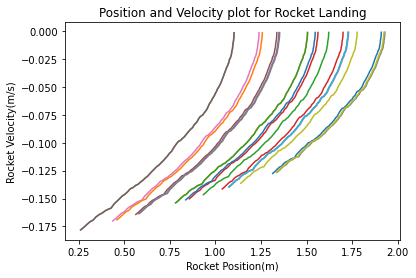

In [39]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 0.0005)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)
plt.show()

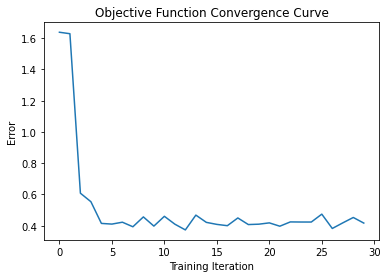

In [40]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

From the figures we can find that the rocket can reach 0 on the X aixs (rocket position) when the final time is approaching. Although, the increase in velocity concerning as it would affect a smooth landing process.

These results show that the controller can not guarantee the design requirment when a large perturbation is provided (High Variance) as the velocity increase could risk the landing process and it would be due to compensation for high variance. 

The convergence curve tells us that it still has a high error when the training iteration is over as compared to the small noise perturbation case. 

This experiments shows that the current controller can only work well based on the given initial distribution when having a small noise perturbation. 

## Considering Rotation
This Portion of the study is to understand if the controller is able to compensate for the inital rotation and whether it would be able to re-orient itself into a veritical orientation and perform a sucessfull landing. An inital orientation of 10 Degrees or 0.1745 radians is considered during the simulation and training of the controller.  

In [31]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

PLATFORM_WIDTH = 0.25  # landing platform width taken from sample
PLATFORM_HEIGHT = 0.06  # landing platform height taken from sample
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.13  # gravity constant
BOOST_ACCEL = 0.20  # thrust constant
ROTATION_ACCEL = 15  # rotation constant
DRAG_ACCEL = 0.003  # drag constant

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action, Noise, mean, variance):
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and drag
        delta_state = (DRAG_ACCEL - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action

        # Noise
        w = t.tensor([1, 0]) * t.tensor(np.random.normal(mean, variance, 1))
        u = t.tensor([0, 1]) * t.tensor(np.random.normal(mean, variance, 1))
        noise = w + u

        # Update velocity
        state = state + delta_state + delta_state_gravity

        # Update state
        step_mat = t.tensor([[1., 0.],
                             [FRAME_TIME, 1.]])
        if Noise == True:
            state = t.matmul(state, step_mat) + noise.float()
        else:
            state = t.matmul(state, step_mat)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, is_Noise, mean, variance):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.is_Noise = is_Noise
        self.mean = mean
        self.variance = variance

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action, self.is_Noise, self.mean, self.variance)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = np.ones((20, 2))
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2, 1)
            state[i][1] = 0.174533 #Considering a 10 degree rotation
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return t.mean(state ** 2)

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss_list = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.loss_list.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(20)])
        for i in range(20):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.title('Position and Velocity plot for Rocket Landing')
        plt.xlabel('Rocket Position(m)')
        plt.ylabel('Rocket Velocity(m/s)')
        plt.show()

## 1. Training the controller with rotation but without noise (Wind Force)

[1] loss: 7.245
[2] loss: 4.767
[3] loss: 3.494
[4] loss: 2.663
[5] loss: 2.063
[6] loss: 1.575
[7] loss: 0.863
[8] loss: 0.491
[9] loss: 0.362
[10] loss: 0.290
[11] loss: 0.243
[12] loss: 0.209
[13] loss: 0.179
[14] loss: 0.160
[15] loss: 0.149
[16] loss: 0.141
[17] loss: 0.134
[18] loss: 0.125
[19] loss: 0.076
[20] loss: 0.066
[21] loss: 0.057
[22] loss: 0.053
[23] loss: 0.050
[24] loss: 0.048
[25] loss: 0.046
[26] loss: 0.044
[27] loss: 0.042
[28] loss: 0.041
[29] loss: 0.039
[30] loss: 0.038


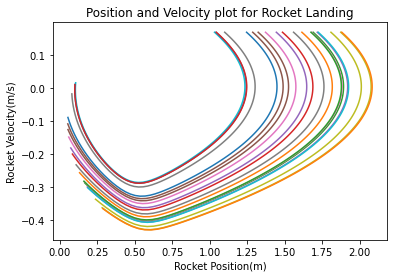

In [2]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = False
mean, variance = (0, 0.000001)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)

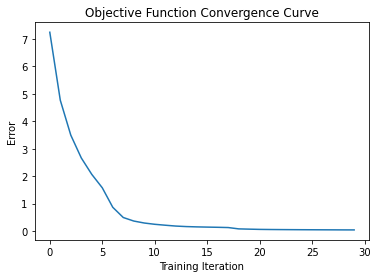

In [3]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

## Discussion
These results depict that the controller was able to ensure that the final postion of the rocket is within the specified bounds of 2 meters but there is an additional velocity component due to the horizontal gravitational component. It would be wise to consider an involvement of a side thruster to ensure 0 velocity at the end of the simulation. This error would reduce if the angle is less as the sine component of gravitational force will increase with the increase in rotational angle. A more general force analysis is represented in the figure below. As this objective function doesn't consider a side thrust force, it is expected to have a small velocity value at the end of the time. Although, the convergence curve for the objective function shows that the objective function is minimized and controller is optimized.  

![Image](https://github.com/toolazytokeep/Design-Optimization/blob/main/Project%201/General%20Rocket%20landing%20force%20frame%20with%20side%20thrust.png?raw=true)

# 2. Training the Controller with rotation and noise

This study is conducted to understand the robustness of controller with a very small noise perturbation which is considered to mimic the wind force which would be experienced by the rocket. We consider a mean value of 0 and variance of $10^{-5}$ for training the controller and to understand its impact on velocity and position of the rocket at the end of the simulation time.  

[1] loss: 3.830
[2] loss: 2.592
[3] loss: 1.894
[4] loss: 1.350
[5] loss: 0.801
[6] loss: 0.532
[7] loss: 0.397
[8] loss: 0.316
[9] loss: 0.261
[10] loss: 0.223
[11] loss: 0.187
[12] loss: 0.164
[13] loss: 0.150
[14] loss: 0.130
[15] loss: 0.079
[16] loss: 0.068
[17] loss: 0.062
[18] loss: 0.058
[19] loss: 0.055
[20] loss: 0.052
[21] loss: 0.051
[22] loss: 0.050
[23] loss: 0.049
[24] loss: 0.048
[25] loss: 0.047
[26] loss: 0.047
[27] loss: 0.046
[28] loss: 0.046
[29] loss: 0.046
[30] loss: 0.046


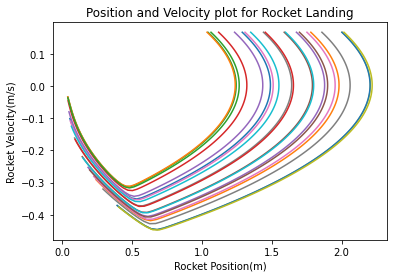

In [4]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 0.00001)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)
plt.show()

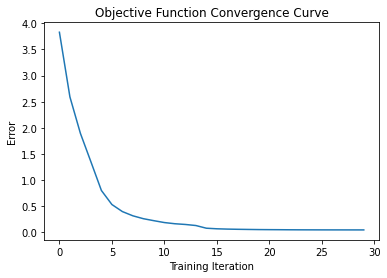

In [5]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

As seen from the graphs the controller was able to compensate for the small perturbations and the objective function was able to converge making the controller optimal for the rocket landing. 

## 3. Training the Controller with large noise perturbation

We want to test the reliability of the controller when having a large noise perturbation. So we increase variance for the noise distribution, which is changed to $5*10^{-4}$.

[1] loss: 4.544
[2] loss: 2.588
[3] loss: 1.894
[4] loss: 1.723
[5] loss: 1.612
[6] loss: 1.236
[7] loss: 1.027
[8] loss: 0.940
[9] loss: 0.917
[10] loss: 0.864
[11] loss: 0.792
[12] loss: 0.886
[13] loss: 0.787
[14] loss: 0.835
[15] loss: 0.848
[16] loss: 0.820
[17] loss: 0.416
[18] loss: 0.450
[19] loss: 0.440
[20] loss: 0.435
[21] loss: 0.415
[22] loss: 0.424
[23] loss: 0.422
[24] loss: 0.473
[25] loss: 0.431
[26] loss: 0.423
[27] loss: 0.482
[28] loss: 0.446
[29] loss: 0.385
[30] loss: 0.412


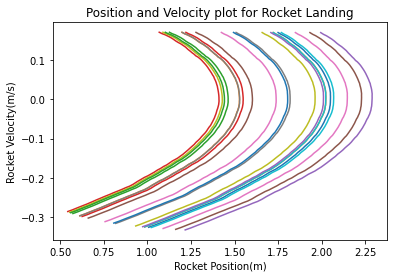

In [33]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 0.0005)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)
plt.show()

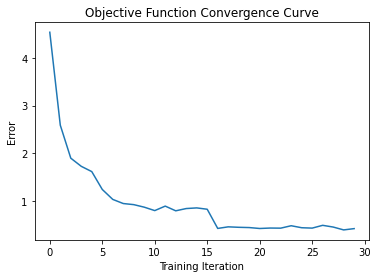

In [34]:
losslistx=[]
for loss in o.loss_list:
    losslistx.append(loss.detach().numpy())
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
plt.plot(losslistx)
plt.show()

As seen from the velocity and position graph, The controller has high error and unable to land the rocket within the specified bounds of 2m as seen from the graph. As the reasoning for not achieving 0 velocity at the end of the time has already been discussed. The results are expected. Although, there is an increase in velocity when the end of simulation is approaching which could be problematic for a smooth landing process. Also, it can be noticed that there is a high training error as compared to the small noise perturbation case which was similar to the simulation without considering inital rotation as the controller is compensating for the large noise by increasing the rocket velocity which is undesirable for landing. 

It can be concluded that the controller needs a side thruster to avoid any velocity component at the end of time and the controller is able to handle small noise perturbations with ease as compared to large noise perturbations. 